# GAN 1-D model from scratch

- 복잡한 Large Neural Network 이 필요 없는 간단한 함수를 이용하여 GAN 의 원리 파악

$$ y = x^2 $$ 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

## 1-D real sample data 생성 함수 작성

- [-0.5, 0.5] 구간의 random sample 을 생성하는 함수 작성  

- np.random.random 이 0-1 사이의 값을 생성하므로 0.5 를 빼준다

(100, 2)


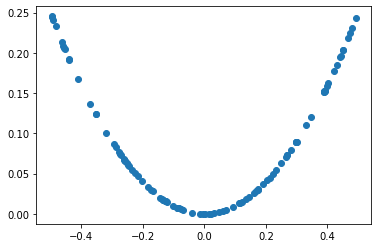

In [2]:
def generate_real_samples(n=100):  
    x1 = np.random.random((n, 1)) - 0.5
    x2 = x1 ** 2
    # input features 구성. [x, x**2]   
    x = np.hstack((x1, x2))  
    return x

plt.figure()
X = generate_real_samples()
print(X.shape)
plt.scatter(X[:, 0], X[:, 1])

In [3]:
real_samples =  generate_real_samples(n=1000)
real_samples.shape

(1000, 2)

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE  = 100

In [5]:
real_dataset = tf.data.Dataset.from_tensor_slices(real_samples)\
                        .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

real_dataset

<BatchDataset shapes: (None, 2), types: tf.float64>

## Generator Model 정의

- generator model 은 latent space 에서 생성된 sample 을 input 으로 하여 2 개의 element 로 구성된 vector 를 출력 (Dense(2))


- latent variable 은 hidden 혹은 관측되지 않는 variable 을 의미하고, latent space 는 latent variables 로 구성된 muti-dimensional vector space 를 의미한다. (random 하게 생성된 정규 분포)


- 우리는 latent space 의 크기 및 latent variables 의 shape과 분포를 정의한 후 latent space 가 우리가 원하는 output sample 의 space 에 대응하도록 training 시킨다. --> generator model training


- 5 dimension 의 small latent space 를 정의(tf.random.normal([100, 5]))하고 각 latent variable 이 latent space 내에서 Gaussian 분포를 취하도록 한다. (평균 0, 표준편차 1)

- inputs : latent space 내의 point (Gaussian random 숫자의 5 element vector)
- outputs : 2 element vector (x 와 $x^2$ 에 해당)


- output 의 1st element 의 값은 [-0.5, 0.5] 구간이고 2nd element 의 값은 1st element를 제곱한 [0.0, 0.25] 구간의 실수이므로 activation 은 linear 를 사용

- training 이 진행되면서 generator 가 생성한 fake samples 가 real samples 의 분포 [-0.5, 0.5] 에 근사


- generator model 은 직접 fit 하지 않으므로 별도로 compile 하지 않고 discriminator 와 함께 compile 한다.

In [6]:
generator = Sequential()
generator.add(Dense(15, activation='relu', 
                    kernel_initializer='he_uniform', input_shape=(5,)))
generator.add(Dense(2))
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


### generator 모델을 이용한 fake sample 생성

- latent space 의 variable (정규 분포 sample)을 이용하여 [-0.5, 0.5] 구간의 real sample 을 모사하도록 훈련

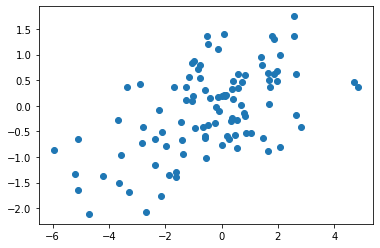

In [7]:
latent = tf.random.normal([100, 5])
fake_samples = generator(latent, training=False)
plt.scatter(fake_samples[:, 0], fake_samples[:, 1])

## Discriminator Model 정의

- sample 이 real 인지 fake 인지 구분하는 binary classifier 작성


- inputs : 두개의 실수로 구성된 sample
- outputs : Binary classification


- 간단한 문제이므로 one hidden layer 의 간단한 model 작성

In [8]:
discriminator =  Sequential()
discriminator.add(Dense(25, activation='relu', 
                        kernel_initializer='he_uniform', input_shape=(2,)))
discriminator.add(Dense(1))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### 손실함수와 optimizer 정의

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 감별자 (Discriminator 손실함수)

- real - 1, fake - 0

In [10]:
def discriminator_loss(real_output, fake_output):
    # [111,,,111] 과 real_output 차이
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # [000,,,,000] 과 fake_output 차이
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 생성자 (Generator 손실함수)

- 감별자가 감별한 output 이 1 이 되면 loss 가 0

In [11]:
def generator_loss(fake_output):
    # [111,,111] 과 fake_output 차이
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 훈련 loop 정의

In [13]:
EPOCHS = 5000
noise_dim = 5  # latent vector 의 dimension
num_examples_to_generate = 16

In [14]:
@tf.function
def train_step(real_samples):
    latent = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # noise 에서 fake image 생성 
        fake_samples = generator(latent, training=True)

        # real image 에 대한 감별자의 output
        real_output = discriminator(real_samples, training=True)
        # fake image 에 대한 감별자의 output
        fake_output = discriminator(fake_samples, training=True)
        
        # fake image 에 대한 감별자의 output 을 all 1 로 만들기 위한 생성자 손실함수
        gen_loss = generator_loss(fake_output)
        # real image 와 fake image 의 total loss 를 minimize 하기 위한 감별자 손실함수
        disc_loss = discriminator_loss(real_output, fake_output)

    # 손실함수와 trainable parameter 지정     
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # gradient update
    generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

In [15]:
def summarize_performance(epoch, generator, discriminator, noise_dim, n=100):
    x_real = generate_real_samples(n)
    y_real = np.ones_like(x_real)
    
    latent = tf.random.normal([n, noise_dim])
    x_fake = generator(latent, training=False)
    y_fake = np.zeros_like(x_fake)
    
    plt.figure()
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.show()

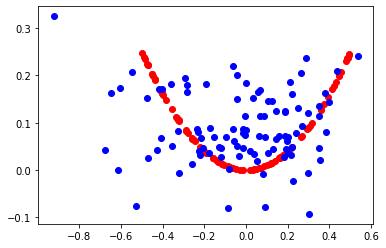

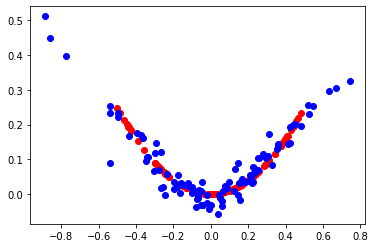

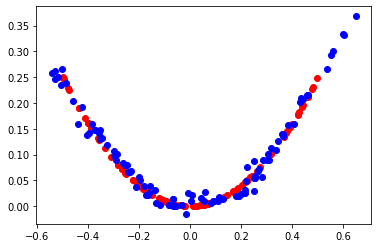

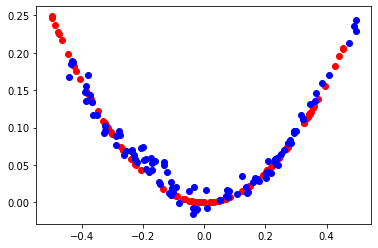

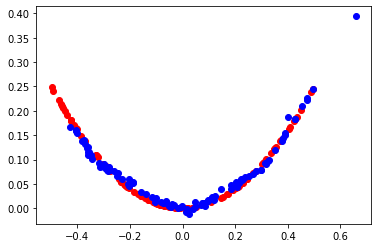

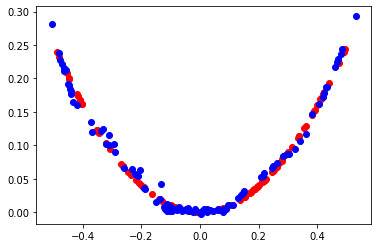

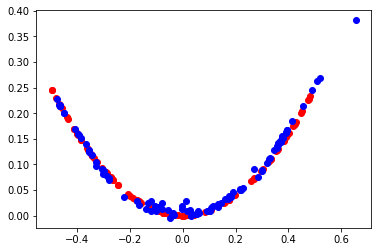

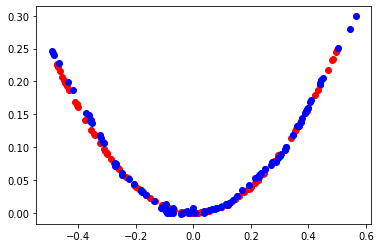

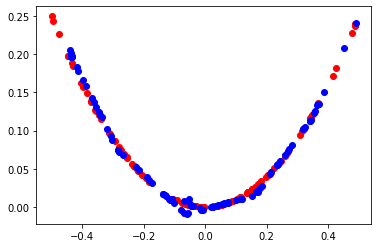

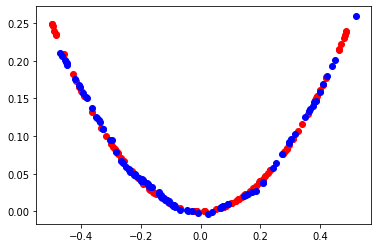

In [17]:
for epoch in range(EPOCHS):
    for sample_batch in real_dataset:
        train_step(sample_batch)
    
    if (epoch+1) % 500 == 0:
        summarize_performance(epoch, generator, discriminator, noise_dim)